# [:+:] __Heart Map__

In [2]:
import os
# import pandas as pd
import numpy as np
# from numpy.random import randint
import matplotlib.pyplot as plt
# from numba import jit, cuda
# import stumpy as sp
from cardiac_ml_tools import read_data_dirs
# from cardiac_ml_tools import get_standard_leads
from cardiac_ml_tools import get_activation_time
# import PIL
import tensorflow as tf
# import keras
from tensorflow import keras, initializers
from keras import Model
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input, Conv2D, Conv1D, Concatenate, \
     MaxPool2D, MaxPool1D, GlobalAvgPool2D, Activation, Dropout, PReLU,BatchNormalization, Flatten,UpSampling2D, LeakyReLU, Dense, Input, add
from keras.losses import MeanSquaredError
from keras.applications import VGG19
# from keras.layers.convolutional import MaxPooling1D
import time
# import tensorly as tl
import itertools
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import glob


## __[+]__ Config
# [DATA]
datapaths_train = r'./intracardiac_dataset/data_hearts_dd_0p2'
datapaths_val = r'./intracardiac_dataset/data_hearts_dd_0p2'
# data_scaling_ecg = normalized_unit
# data_scaling_vm = normalization
num_timesteps = 500
all_channels = True
input_dim = 12
output_dim = 75

# [MODEL]
hidden_dim = 100
layer_dim = 2

# [TRAIN]
learning_rate = 1e-3
gamma_scheduler = 1.0
step_size_scheduler = 100
batch_size = 32
num_epochs = 10
grad_clippling = False
dropout = 0.0
loss_norm = 'MSE' #keras.losses import MeanSquaredError
load_model = False
model_path = r'./intracardiac_dataset/data_hearts_dd_0p2'

# [SAVE]
# outputstats_file = trainingStats
checkpoint_rate = 200
# out_name = mymodel
progressbar = False


# device_name = tf.test.gpu_device_name()
# print('Device: ', device_name)
# if device_name != '':
#     device_name = "GPU"
# else:
#     device_name = "CPU"
# print('\nThe device is {}\n'.format(device_name))


# TensorFlow automatically uses the appropriate device
# model = SqueezeNet(version='1_1', dropout=dropout, kernel_size=knl)  
# model = model.to(device)

# Squeezenet/Mikelnet: 
    #loss function: 'squared error'  :keras.losses import MeanSquaredError
    #test-train split: random 95/5
    #optimizer: adam
    #Learning rat: 0.001


## (batchCount, batch_size, signalCount, timeSteps)


# ecg_test_T= np.load('ecg_test_T.npy')
# print('ecg_test_T: ', ecg_test_T.shape)
# vm_test_T= np.load('vm_test_T.npy')
# print("\nvm_test_T:  ", vm_test_T.shape)

# ecg_testBat32_T= np.load('ecg_testBat32_T.npy')
# print('ecg_testBat32_T: ', ecg_testBat32_T.shape)
# vm_testBat32_T= np.load('vm_testBat32_T.npy')
# print("\nvm_testBat32_T:  ", vm_testBat32_T.shape)
# print("\nvm_batches: ", vm_batches.shape)

# ecg_norm= np.load('X_norm.npy')
# vm_norm= np.load('Y_norm.npy')
# print('\necg_norm: ' ,ecg_norm.shape)
# print('\nvm_norm: ' ,vm_norm.shape)


# vm_norm_T= np.load(r'vm_norm_T.npy')
# ecg_norm_T= np.load(r"ecg_norm_T.npy")
# print('vm_norm_T: ', vm_norm_T.shape)
# print('ecg_norm_T: ', ecg_norm_T.shape)

# ecg_train, ecg_test, vm_train, vm_test= train_test_split(ecg_norm, vm_norm, test_size= 0.05, random_state=42)
# ecg_train, ecg_test, vm_train, vm_test= train_test_split(ecg_norm_T, vm_norm_T, test_size= 0.05, random_state=42)
# print('\necg_train, ecg_test, vm_train, vm_test: ', ecg_train.shape, ecg_test.shape, vm_train.shape, vm_test.shape)



2023-07-21 12:42:17.777462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 12:42:19.743814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/koogleblitz/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## [+] Data Preparation

In [2]:
#[+]-- Data Prep
data_Path= r'../intracardiac_dataset/'
data_folders= os.listdir(data_Path)
npyFolders= filter(lambda x: 'data' in x and os.path.isdir(os.path.join(data_Path, x)), data_folders)
npyFolders= np.char.array(list(npyFolders))
# samplePair= np.array(read_data_dirs(verbose=1))
# print(samplePair.shape)

#[+] -- Create Pairs
pairings= {}
for i,folder in enumerate(npyFolders):
    directory= os.path.join(data_Path, folder) + '/'
    pairs= np.array(read_data_dirs(dirs_names = [directory], verbose  = 1))
    pairings.update({i:pairs})
    print( directory, '-->' , pairs.shape, '\n')

#[+]-- view pairings
    # Format: pairings[folder#][pair#][0=ecg, 1=Vm]
pairCnt= 0
for folder in pairings:
    for pair in pairings[folder]: pairCnt+=1
print(pairCnt)


#### [+] Convert 10-Lead ECG signals into 12-Lead EGC Signals
# ecg_std= {}
# for k,fldr in pairings.items():
#     for pairs in fldr:
#         stdLead= np.load(pairs[0])
#         ecg_std.update({k:get_standard_leads(stdLead)})
# print(ecg_std[k].shape)

#### [+]-- Get Activation Times from Transmembrane Voltages
activations= {}
for k,fldr in pairings.items():
    for pairs in fldr:
        transVolt= np.load(pairs[1])
        activations.update({k:get_activation_time(transVolt)})
        print(activations[k].shape)

# dataDict= [pairings, ecg_std]
# with open('dataDict.pickle', 'wb') as f:
#     pickle.dump(dataDict, f)

# with open('dataDict.pickle', 'rb') as f:
#     dataDict= pickle.load(f)

# pairings= dataDict[0]
# ecg_std= dataDict[1]

Reading files... done.
len(files_pECG) : 699
len(files_Vm) : 699
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl_gkr/ --> (699, 2) 

Reading files... done.
len(files_pECG) : 450
len(files_Vm) : 450
../intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_2_bcl/ --> (450, 2) 

Reading files... done.
len(files_pECG) : 699
len(files_Vm) : 699
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/ --> (699, 2) 

Reading files... done.
len(files_pECG) : 700
len(files_Vm) : 700
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl_gkr/ --> (700, 2) 

Reading files... done.
len(files_pECG) : 450
len(files_Vm) : 450
../intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl/ --> (450, 2) 

Reading files... done.
len(files_pECG) : 1040
len(files_Vm) : 1040
../intracardiac_dataset/data_hearts_dd_0p2_geo_act_2_bcl_gkr_I/ --> (1040, 2) 

Reading files... done.
len(files_pECG) : 1781
len(files_Vm) : 1781
../intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_1_bcl_I/ --> (1781, 2

### [+] Save & Load Data

In [ ]:
# # Format: pairings[folder#][pair#][0=ecg, 1=Vm]
# ecgMatrix= np.empty((0,))
# ecgCnt= 0
# for folder in pairings:
#     for pair in pairings[folder]:
#         ecgCnt+=1 
#         ecg= np.load(pair[0])
#         ecg_std= get_standard_leads(ecg)
#         ecgMatrix= np.append(ecgMatrix, ecg_std)

# #129minutes!!!!:
# voltMatrix= np.empty((0,))
# voltCnt= 0
# for folder in pairings:
#     for pair in pairings[folder]:
#         voltCnt+=1 
#         volt= np.load(pair[1])
#         voltMatrix= np.append(voltMatrix, volt)
# # print(' ecgs: ', ecgCnt, '\n', 'transmemberant voltages: ', voltCnt, '\n', 'pairs: ', pairCnt)
# print(ecgMatrix.shape)
# print(ecgMatrix.shape[0]/500)

# np.save('voltMatrix_tmp.npy', voltMatrix)
# np.save('ecgMatrix_tmp.npy', ecgMatrix)


#23minutes
# ecgTensor_tmp= np.load('ecgMatrix_tmp.npy')
# ecgTensor= np.empty((500,12,1))  
# for i in itertools.count(500*12, 500*12):
#     if i > ecgTensor_tmp.shape[0]: break
#     segment= ecgTensor_tmp[i-500*12:i].reshape(500, 12, 1)
#     ecgTensor= np.concatenate((ecgTensor, segment), axis=2)
# ecgTensor= ecgTensor[:, :, 1:]
# print(ecgTensor.shape)
# np.save('ecgTensor.npy', ecgTensor)
# ecgTensor= np.load('ecgTensor.npy')
# print(ecgTensor.shape)
# plt.figure(figsize = (20//2, 10//2))
# plt.plot(range(500), ecgTensor[:, :, 0])
# plt.show()
    
# #163 Minutes !!!!  
# vmTensor_tmp= np.load('voltMatrix_tmp.npy')
# voltTensor= np.empty((500,75,1))  
# for i in itertools.count(500*75, 500*75):
#     if i > vmTensor_tmp.shape[0]: break
#     segment= vmTensor_tmp[i-500*75:i].reshape(500, 75, 1)
#     voltTensor= np.concatenate((voltTensor, segment), axis=2)
# print(voltTensor.shape)
# np.save('voltTensor.npy', voltTensor[:, :, 1:])
# voltTensor= np.load('voltTensor.npy')
# print(voltTensor.shape)
# plt.figure(figsize = (20//2, 10//2))
# plt.plot(range(500), voltTensor[:, :, 0])
# plt.show()


##for later maybe:
# ecgTensor= np.load('ecgTensor.npy')
# pairs= ecgTensor.shape[2]
# ecgTensor_RS= np.empty((0, 500, 12))
# for i in itertools.count(0, 1):
#     if i>=pairs: break
#     frame = ecgTensor[:, :, i].reshape(1, 500, 12)
#     ecgTensor_RS= np.concatenate((ecgTensor_RS, frame ), axis= 0)


# print(ecgTensor_RS.shape)
# plt.figure(figsize = (20//3, 10//3))
# plt.plot(range(500), ecgTensor_RS[0])
# plt.show()


# voltTensor= np.load('voltTensor.npy')
# print('voltTensor: ', voltTensor.shape, '\n\n')
# yLoader(voltTensor= voltTensor)

# ecgTensor= np.load('ecgTensor.npy')
# print('ecgTensor: ', ecgTensor.shape, '\n')
# xLoader(ecgTensor= ecgTensor)


# voltTensor= np.load('voltTensor.npy')
# pairs= voltTensor.shape[2]
# voltTensor_RS= np.empty((0, 500, 75))
# for i in itertools.count(0, 1):
#     if i>=pairs: break
#     frame = voltTensor[:, :, i].reshape(1, 500, 75)
#     voltTensor_RS= np.concatenate((voltTensor_RS, frame ), axis= 0)


# print(voltTensor_RS.shape)
# plt.figure(figsize = (20//3, 10//3))
# plt.plot(range(500), voltTensor_RS[0])
# plt.show()

## __[+]__ FX Components

In [3]:
## Old Stuff
class Fire_1D(layers.Layer):
    def __init__(self, initShape,sqExpand,exFilter_1x1, exFilter_3x3):
        super(Fire_1D, self).__init__()
        self.squeeze    =  Conv1D(input_shape= (None, initShape), filters= sqExpand,     kernel_size=1, activation='relu')
        self.expand_1x1 =  Conv1D(input_shape= (None,sqExpand),   filters=exFilter_1x1,  kernel_size=1, activation='relu')
        self.expand_3x3 =  Conv1D(input_shape= (None,sqExpand),   filters= exFilter_3x3, kernel_size=3, activation='relu', padding=1)
    def call(self, x):
        squeezed= self.squeeze(x)
        expanded_1x1= self.expand_1x1(squeezed)
        expanded_3x3= self.expand_3x3(squeezed)
        x= Concatenate()([expanded_1x1, expanded_3x3])
        # x= Activation('relu')(x)
        return x 
class MikelNet_t4(keras.Model):
    def __init__(self, dropout=0.5, kernel_size=3):
        super(MikelNet_t4, self).__init__()
        self.features = keras.Sequential([
            layers.Conv1D(filters= 64,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='relu'),
            layers.MaxPool1D(pool_size=kernel_size,
                             strides=1,
                             padding='same'),
            Fire_1D(64, 16, 64, 64),
            Fire_1D(128, 16, 64, 64),
            layers.MaxPool1D(pool_size=kernel_size,
                             strides=1,
                             padding='same'),
            Fire_1D(128, 32, 128, 128),
            Fire_1D(256, 32, 128, 128),
            layers.MaxPool1D(pool_size=kernel_size,
                             strides=1,
                             padding='same'),
            Fire_1D(256, 48, 192, 192),
            Fire_1D(384, 48, 192, 192),
            Fire_1D(384, 64, 256, 256),
            Fire_1D(512, 64, 256, 256)
        ])
        self.classifier = keras.Sequential([
            Dropout(rate=dropout),
            Conv1D(75, kernel_size=1, padding='valid')
        ])
        # Initialization
        for layer in self.layers:
            if isinstance(layer, tf.keras.layers.Conv1D):
                layer.kernel_initializer = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='uniform')
            if layer.bias is not None:
                layer.bias_initializer = initializers.Zeros()
        def call(self, x):
            x= self.features(x)
            x= self.classifier(x)
            return x
        
# class Fire_1D(layers.Layer):
#     def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
#         super(Fire_1D, self).__init__()
#         self.squeeze = layers.Conv1D(squeeze_planes, kernel_size=1)
#         self.squeeze_activation = layers.ReLU()
#         self.expand1x1 = layers.Conv1D(expand1x1_planes, kernel_size=1)
#         self.expand1x1_activation = layers.ReLU()
#         self.expand3x3 = layers.Conv1D(expand3x3_planes, kernel_size=3, padding='same')
#         self.expand3x3_activation = layers.ReLU()
#     def call(self, x):
#         x = self.squeeze_activation(self.squeeze(x))
#         return tf.concat([
#             self.expand1x1_activation(self.expand1x1(x)),
#             self.expand3x3_activation(self.expand3x3(x))
#             ], axis=-1)

In [3]:
def squeezEx_fx(inputs, ratio=8):
    bat, h, w, ch= inputs.shape
    print('---[+]input: ',bat, h, w, ch)
    
    #Squeeze
    x= GlobalAveragePooling2D()(inputs)
    print('---[+]squeezed input: ',x.shape)

    #Exite
    x= Dense(ch//ratio, activation= "relu", use_bias= False)(x)
    x= Dense(ch, activation= "sigmoid", use_bias= False)(x)
    print('---[+]exited input: ', x.shape)

    #Scale
    x= inputs*x
    print('---[+]scaled: ', x.shape)

    return x
# sampInput= Input(shape= (128,128,32))
# squeezEx(sampInput)



### __[+]__ Super Resolution GAN Modules------------------------------------------
def res_block(ip):
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    return add([ip,res_model])
def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    return up_model
def buildGenerator(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)
def discriminator_block(ip, filters, strides=1, batNorm=True):
    # disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    # if batNorm:
    #     disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    # disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    # return disc_model
    tensor= Conv2D(filters, (3,3), strides= strides, padding="same")(ip)
    if batNorm: tensor= BatchNormalization(momentum=0.8)(tensor)
    tensor= LeakyReLU(alpha=0.2)(tensor)
    return tensor
def buildDiscrminator(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, batNorm=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(disc_ip, validity)
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)
def buildSuperRez(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])
#-----------------------------------------------------------------------------------//



#[+]-----------MikelNet----------------------------------------------------------------------------\\
# torch.nn.Conv1d(n_channels =12, out_channels =96, kernel_size=7, stride=2)
#[+:] sqExpand: the output shape of the squeeze layer is the input shape of the expand layers
def fire_1D_fx(x,  initShape,sqExpand,exFilter_1x1, exFilter_3x3):
    squeezed     =  Conv1D(input_shape= (None, initShape), filters= sqExpand, kernel_size=1, activation='relu')(x)
    expanded_1x1 =  Conv1D(input_shape= (None,sqExpand), filters=exFilter_1x1,  kernel_size=1, activation='relu')(squeezed)
    expanded_3x3 =  Conv1D(input_shape= (None,sqExpand), filters= exFilter_3x3, kernel_size=3, activation='relu', padding='same')(squeezed)
    x= Concatenate()([expanded_1x1, expanded_3x3])
    print('        [fire_1D_fx:]:==> x', x.shape)
    # x= Activation('relu')(x)
    return x  

def ecg2vm_fx(x, dropout= 0.5, kernel_size = 3):
    print('\n[:+:] --------------------------------------------------------------------------- [:+:]\n')
    # Conv1D(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    #[+]-- Conv1D layers expect their input to have a rank of 3, with dimensions (batch_size, steps, input_dim). so not sure if (12,500) is correct
    # x = Reshape((12, 500))(x)
    print('x--> [ecg2vm_fx]: ', x.shape)
    x = Reshape((500,12))(x)
    print('x--> [ecg2vm_fx.Conv1D] reshaped: ', x.shape)
    x= Conv1D(input_shape= (None,12), filters=64, kernel_size=kernel_size, strides=1, padding='same')(x)
    print('    \nx--> [MaxPool1D_1] : ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,64, 16, 64, 64)
    x= fire_1D_fx(x,128, 16, 64, 64)
    print('    \nx--> [MaxPool1D_2]: ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,128, 32, 128, 128)
    x= fire_1D_fx(x,256, 32, 128, 128)
    print('    \nx--> [MaxPool1D_3]: ', x.shape)
    x= MaxPool1D(pool_size=kernel_size, strides=1, padding='same')(x)
    x= fire_1D_fx(x,256, 48, 192, 192)
    x= fire_1D_fx(x,384, 48, 192, 192)
    x= fire_1D_fx(x,384, 64, 256, 256)
    x= fire_1D_fx(x,512, 64, 256, 256)
    print('\n    [ecg2vm_fx:]:==> x', x.shape)
    return x
def finalConv_fx(x, dropout= 0.5):
    print('\nx --> [finalConv_fx]: ', x.shape)
    Dropout(rate=dropout)
    x=Conv1D(filters=75, kernel_size=1, padding='valid', input_shape=(None, 512))(x)
    print('\n          [finalConv_fx:]:=====> x', x.shape)
    return x
# def buildSuperRez(gen_model, disc_model, vgg, lr_ip, hr_ip):
#     gen_img = gen_model(lr_ip)
#     gen_features = vgg(gen_img)
#     disc_model.trainable = False
#     validity = disc_model(gen_img)
#     return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])
def build_ecg2vm(main_fx, finalConv_fx, ecg_ip, vm_ip):
    x= main_fx(ecg_ip)
    y_pred= finalConv_fx(x)
    print('\nbuild_ecg2vm: finalConv_fx(x):= y_pred=    ', y_pred.shape, type(y_pred))
    y_truth= vm_ip
    print('build_ecg2vm: y_truth=     ', y_truth.shape, type(y_truth))
    print(" type of 'none': ", type(y_truth.shape[0]))
    # mse= MeanSquaredError(y_truth, y_pred)
    #[+]--
    return Model(inputs= ecg_ip, outputs= y_pred )
    # return Model(inputs= [ecg_ip, vm_ip], outputs= y_pred )
#-----------------------------------------------------------------------------------//


## __[+]__ Data Loading

In [ ]:
### Reference
class Ecg2VmDataset(tf.data.Dataset):
    def __init__(self, file_pairs, outLead, num_timesteps, scaling_ecg='none', scaling_vm='none', noise_ecg='none', noise_vm='none'):
        # This is needed in the __getitem__ method
        self.initial_time_aug = initial_time_aug
        self.num_timesteps = num_timesteps
        # First time we concatenate to global tensor
        initialized = False

        self.X = tf.zeros((len(file_pairs), 12, num_timesteps))
        self.Y = tf.zeros((len(file_pairs), len(outLead), num_timesteps))
        for i, pair in enumerate(file_pairs):
            print(f'Processing files {pair[0]} {pair[1]} ...', end='')
            dataECG = tf.convert_to_tensor(np.load(pair[0]))
            dataVm = np.load(pair[1])
            # dataVm = tf.convert_to_tensor(np.load(pair[1]))
            
            if not noise_ecg == 'none':
                tf.random.set_seed(i)
                noiseECG = tf.random.normal(dataECG.shape, stddev=noise_ecg)
                dataECG = dataECG + noiseECG
            if not noise_vm == 'none':
                tf.random.set_seed(i)
                noiseVm = tf.random.normal(dataVm.shape, stddev=noise_vm)
                dataVm = dataVm + noiseVm

            ecg12aux = tf.zeros(dataECG.shape[0], 12)
            WilsonLead = 0.33333333 * (dataECG[:, 0] + dataECG[:, 1] + dataECG[:, 2])
            # ecg12aux[:, 0] = dataECG[:, 1] - dataECG[:, 0]

            ##[+]-- "Wilson Lead"  is used to transform the 10 lead to the 12 lead, can be ignored for now-----------------------------------------------------------------------------
            ecg12aux = ecg12aux[:, 0].assign(dataECG[:, 1] - dataECG[:, 0])
            ecg12aux[:, 1] = dataECG[:, 2] - dataECG[:, 0]
            ecg12aux[:, 3] = 1.5 * (dataECG[:, 0] - WilsonLead)
            ecg12aux[:, 4] = 1.5 * (dataECG[:, 1] - WilsonLead)
            ecg12aux[:, 5] =  1.5 * (dataECG[:, 2] - WilsonLead)
            ecg12aux[:, 6] = dataECG[:, 4] - WilsonLead
            ecg12aux[:, 7] = dataECG[:, 5] - WilsonLead
            ecg12aux[:, 8] =  dataECG[:, 6] - WilsonLead
            ecg12aux[:, 9] =  dataECG[:, 7] - WilsonLead
            ecg12aux[:, 10] = dataECG[:, 8] - WilsonLead
            ecg12aux[:, 11] = dataECG[:, 9] - WilsonLead
            # ecg12aux = ecg12aux[:, 5].assign(1.5 * (dataECG[:, 2] - WilsonLead))
            # ecg12aux = ecg12aux[:, 8].assign(dataECG[:, 6] - WilsonLead)
            # ecg12aux = ecg12aux[:, 9].assign(dataECG[:, 7] - WilsonLead)
            # ecg12aux = ecg12aux[:, 10].assign(dataECG[:, 8] - WilsonLead)
            # ecg12aux = ecg12aux[:, 11].assign(dataECG[:, 9] - WilsonLead)
            dataECG = ecg12aux


        #[+]---------------------------------- ECG Normalization options----------------------------------------------------------------------------------------
            if scaling_ecg.lower() in ('normalized', 'normalization'):
                min_ECG = tf.convert_to_tensor([-5.9542925, -5.5712219, -3.57188496, -4.288217553657807, -4.222570670021488, -3.156398588951382, -2.447856981540037, -2.3431330150222047, -2.514583015022205, -2.310517893645093, -1.9708348277623609, -2.32984159187901])
                max_ECG = tf.convert_to_tensor([4.5093912, 4.2175924, 4.23887649, 5.473125233494979, 3.555297089959163, 3.018831728255531, 2.984374763664689, 2.359350064582923, 2.205404624762396, 2.014215222417507, 1.7023503410995358, 2.128710478327503])
                dataECG = (dataECG - min_ECG) / (max_ECG - min_ECG)
            if scaling_ecg.lower() in ('normalized_zero', 'normalization_zero'):           
                min_ECG = tf.Tensor([-5.9542925, -5.5712219, -3.57188496, -4.288217553657807, -4.222570670021488, -3.156398588951382, -2.447856981540037, -2.3431330150222047, -2.514583015022205, -2.310517893645093, -1.9708348277623609, -2.32984159187901]);
                max_ECG = tf.Tensor([4.5093912, 4.2175924, 4.23887649, 5.473125233494979, 3.555297089959163, 3.018831728255531, 2.984374763664689, 2.359350064582923, 2.205404624762396, 2.014215222417507, 1.7023503410995358, 2.128710478327503]); 
                dataECG = dataECG/(max_ECG - min_ECG)
            if scaling_ecg.lower() in ('normalized_unit', 'normalization_unit'):
                diff_ECG = tf.reduce_max(ecg12aux) - tf.reduce_min(ecg12aux)
                dataECG = dataECG / diff_ECG    
            if scaling_ecg.lower() in ('standardized', 'standardization'): 
                mean_ECG = tf.Tensor([0.05337660278745852, 0.07800385312690625, 0.024627250339440174, -0.06569022815751291, 0.014374676023680694, 0.05131555153284552, -0.010237228016673849, -0.003921020891815309, 0.0022406280086986834, 0.009890627175816347, 0.028677603573294373, 0.03275114376978516]);
                std_ECG = tf.Tensor([0.5222836421647369, 0.46912923915554305, 0.37388222388756165, 0.4598741596222561, 0.3889260864136291, 0.33427537906748767, 0.3705529026825294, 0.2952769469657289, 0.25925690993927925, 0.22944537376676, 0.1901723804732019, 0.21860623885510164]);             
                dataECG = (dataECG - mean_ECG)/std_ECG 

        #[+]---------------------------------- Transmembrane Voltage Normalization options---------------------------------------------------------------------                                                    
            if scaling_vm.lower() in ('normalized', 'normalization'):
                min_Vm = -85.50618677
                max_Vm = 50
                dataVm = (dataVm - min_Vm) / (max_Vm - min_Vm)
            if scaling_vm.lower() in ('standardized', 'standardization'):
                mean_Vm = tf.convert_to_tensor([-27.02603307424577, -26.42599561013216, -27.08525685162167, -27.072770564186968, -27.243808102053098, -27.223278514349435, -27.083835486582533, -27.4110323325722, -27.331364526546558, -27.292912836782325, -27.2623019983753, -27.309269034155918, -27.338672021582383, -26.96347544613768, -27.158927183083865, -27.148198380852556, -26.883271193655993, -27.257562163163644, -27.415302995291814, -26.94089741455307, -26.380328171515497, -25.54398827003744, -23.23964030494721, -23.786303859496492, -24.34536973736025, -22.657021527711205, -22.97386209700062, -24.401331456790917, -22.85421172290724, -23.53197373751619, -22.835052832991884, -22.262005001437203, -22.455317361231046, -22.89109758332462, -22.188754372239817, -23.255352662227548, -24.477588837594464, -21.57554287398308, -23.21185108937846, -24.408397658499197, -23.575402103548807, -22.70741982489576, -23.26547254656032, -22.556876909612093, -23.473493713381124, -23.17731478310807, -23.3978924708568, -24.21465872516993, -24.124127267631177, -23.007716729212664, -21.946535996882478, -23.82175334518444, -22.123872753464493, -22.58709327049051, -22.922965821427884, -21.81210974698793, -23.108769012452854, -23.667390240852303, -23.176059221741134, -24.46574628391638, -24.280569203528557, -24.02632635847834, -24.47809251732797, -24.53259190412837, -21.119403077336877, -23.46734272271838, -22.150611059141283, -20.056483455611414, -23.7378480642948, -25.00461526170495, -25.54193419748148, -26.139503214725956, -24.044751574496654, -18.106829931867534, -24.050961364158532])
                std_Vm = tf.convert_to_tensor([47.641536695345756, 48.06899998911084, 48.07414930671482, 48.11237730036997, 48.129058287035924, 48.0640893651176, 48.04744258911431, 48.13517961142586, 48.11835490821148, 47.962570832683326, 48.045036073334025, 48.10542334800333, 48.1246977818833, 48.050984724069615, 48.150803515787764, 48.06273803810126, 48.14493033200949, 48.12373790487682, 47.94787316863915, 48.02717365919841, 48.16793355687098, 47.43404028501432, 47.69275264593347, 47.429461227850354, 47.27577038148137, 47.483485304378185, 47.35513468894153, 47.476477552939, 47.40493732227091, 47.36480405400306, 47.27410640503226, 47.326784740079724, 47.14305866446591, 47.14583848299832, 47.199156343425514, 47.34212272065462, 47.28098038286131, 47.327434856895884, 47.41420703719095, 47.40323474130151, 47.35621333118535, 47.23712532841057, 47.27712443301808, 47.32096036086348, 47.36162912212813, 47.254781765575274, 47.51120274336878, 47.573638059579956, 47.39408888626409, 47.22356400053576, 47.1674285402863, 47.07278873397787, 47.37766720677062, 47.180738258200996, 47.107764513714976, 47.39300851962479, 47.13585147999253, 47.44995913959363, 47.58919183197946, 47.60075423860692, 47.519772776916206, 47.668316011259535, 47.64926124185182, 47.36382151594125, 47.22019575795546, 47.17374251749065, 47.035487361419165, 47.01706929688778, 47.22759542323285, 47.63130076314641, 47.79796415558373, 47.84059288765446, 47.06397431137122, 46.780332763572964, 47.112581773104374])
                dataVm = (dataVm - mean_Vm)/std_Vm
            
            self.X[i,:,:].assign(dataECG[0:num_timesteps,:].numpy().T)
            self.Y[i,:,:].assign(dataVm[0:num_timesteps,outLead].numpy().T)
            print('done.')

        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index,:,:], self.Y[index,:,:]
    def __len__(self):
        return self.len

In [117]:

def xLoader_noT(ecgTensor):
    # ecgTensor= tf.convert_to_tensor(ecgTensor)
    timeSteps, inLeads, pairs= ecgTensor.shape
    print('\n[+]-- time, inleads, pairs= ', ecgTensor.shape, '\n')
    X = np.zeros((pairs, timeSteps, inLeads))
    # X = np.zeros((pairs, inLeads, timeSteps))
    # X = tf.zeros(pairs, inLeads, timeSteps)
    # Y = tf.zeros(pairs, outLeads, timeSteps)
    for i in itertools.count(0, 1):
        if i>=pairs: break 
        #-------------------------------------------------------------------------------|
        #[+]-- Normalization: 'normalized_unit' option for ecg, 'normalized' option for Vm ---------------------
        # diff_ECG = tf.reduce_max(ecg12aux, axis=0) - tf.reduce_min(ecg12aux, axis=0)
        # dataECG = dataECG / diff_ECG 

        ecgMat= ecgTensor[:, :, i]
        diff_ECG = tf.reduce_max(ecgMat, axis=0) - tf.reduce_min(ecgMat, axis=0)
        ecgNormMat = ecgMat / diff_ECG
        X[i,:,:]= ecgMat
        # X[i,:,:]= dataECG[0:timeSteps,:].numpy().T
    np.save('ecg_norm.npy', X)

def yLoader(voltTensor):
    timeSteps, outLeads, pairs= voltTensor.shape
    print('\n [+]-- time, outleads, pairs= ', voltTensor.shape, '\n')

    Y= np.zeros((pairs, outLeads, timeSteps ))
    for i in itertools.count(0, 1):
        if i>=pairs: break
        
        #[+] --- process noise --
        # def addNoise():

        #[+]-- Normalization: 'normalized_unit' option for ecg, 'normalized' option for Vm ---------------------
        voltMatrix= voltTensor[:, :, i]
        min_Vm = -85.50618677
        max_Vm = 50
        voltMatrix= (voltMatrix - min_Vm) / (max_Vm - min_Vm)
        Y[i,:,:]= voltMatrix[0:timeSteps,:].T
    np.save('Y_norm.npy', Y)

def batchify(data, batchSize=32, printerval=100):
    batched= []
    for i in itertools.count(0, 1):
        if i>=(data.shape[0]//batchSize): break
        beginDex= i*batch_size
        enDex= beginDex+batch_size
        batched.append(data[beginDex:enDex])
        if i%printerval==0: print('ecg batches made: ', i)
    batched= np.array(batched)
    # np.save(r"C:\Users\richa\OneDrive\DSC\myData\ecg_trainBat32_T.npy", batched)
    # batched= np.load(r"C:\Users\richa\OneDrive\DSC\myData\ecg_trainBat32_T.npy")
    # print('\necg_trainBat32_T saved', batched.shape)
    return batched


# ecgTensor= np.load('ecgTensor.npy')
# print('ecgTensor: ', ecgTensor.shape)
# xLoader_noT(ecgTensor)

# ecgNorm= np.load('ecg_norm.npy')
# print('ecgNorm loaded: ', ecgNorm.shape, type(ecgNorm))

# ecgNorm_bat32= batchify(ecgNorm)
# np.save('ecgNorm_bat32.npy', ecgNorm_bat32)
# np.load('ecgNorm_bat32.npy')
# print('ecgNorm_bat32 saved: ', ecgNorm_bat32.shape)



16096


In [ ]:
print(ecgNormMat[0])
plt.plot(range(500), ecgNormMat)
plt.show()
print(ecg_norm_T[0][0])
plt.plot(range(500), ecg_norm_T[0])
plt.show()

#### Train/Test Split + Batchify

In [ ]:
#[+:]-- commented out after split have been made and batches have been saved

# ecg_norm= np.load('X_norm.npy')
# vm_norm= np.load('Y_norm.npy')
# print('ecg_norm: ', ecg_norm.shape)
# print('vm_norm: ', vm_norm.shape)


# ecg_norm_T= []
# for i in itertools.count(0, 1):
#     if i>=(ecg_norm.shape[0]): break
#     ecg_norm_T.append(ecg_norm[i].T)
#     if i%100==0: print('idx: ', i)
# ecg_norm_T= np.array(ecg_norm_T)
# np.save('ecg_norm_T.npy', ecg_norm_T)
# print(ecg_norm_T.shape)


# vm_norm_T= []
# # for i in range(vm_norm.shape[0]):
# for i in itertools.count(0, 1):
#     if i>=(vm_norm.shape[0]): break
#     vm_norm_T.append(vm_norm[i].T)
#     if i%100==0: print('idx: ', i)
# vm_norm_T= np.array(vm_norm_T)
# print(vm_norm_T.shape)
# np.save('vm_norm_T.npy', vm_norm_T)


# tmp= np.load(pairings[0][0][1])
# print(vm_norm_T[0].shape)
# plt.plot(range(500), vm_norm_T[0])
# plt.show()
# print(tmp.shape)
# plt.plot(range(500), tmp)
# plt.show()


# ecg_train, ecg_test, vm_train, vm_test= train_test_split(ecg_norm, vm_norm, test_size= 0.05, random_state=42)
# print('\necg_train, ecg_test, vm_train, vm_test: ', ecg_train.shape, ecg_test.shape, vm_train.shape, vm_test.shape)


# ecg_batches= []
# for i in itertools.count(0, 1):
#     if i>=(ecg_train.shape[0]//batch_size): break
#     beginDex= i*batch_size
#     enDex= beginDex+batch_size
#     ecg_batches.append(ecg_train[beginDex:enDex])
#     if i%batch_size==0: print('ecg batches made: ', i)
# ecg_batches= np.array(ecg_batches)
# print("\necg_batches:  ", ecg_batches.shape)
# np.save('ecg_batches.npy', ecg_batches)

# vm_batches= []
# for i in itertools.count(0, 1):
#     if i>=(vm_train.shape[0]//batch_size): break
#     beginDex= i*batch_size
#     enDex= beginDex+batch_size
#     vm_batches.append(vm_train[beginDex:enDex])
#     if i%batch_size==0: print('voltages batches made: ', i)
# vm_batches= np.array(vm_batches)
# print("\nvm_batches: ", vm_batches.shape)
# np.save('vm_batches.npy', vm_batches)

#-------------------------------------------------------------

# ecg_batches_T= []
# for i in itertools.count(0, 1):
#     if i>=(ecg_train.shape[0]//batch_size): break
#     beginDex= i*batch_size
#     enDex= beginDex+batch_size
#     ecg_batches_T.append(ecg_train[beginDex:enDex])
#     if i%batch_size==0: print('ecg batches made: ', i)
# ecg_batches_T= np.array(ecg_batches_T)
# print("\necg_batches_T:  ", ecg_batches_T.shape)
# np.save('ecg_batches_T.npy', ecg_batches_T)

# ecg_testBat32_T= []
# for i in itertools.count(0, 1):
#     if i>=(ecg_test.shape[0]//batch_size): break
#     beginDex= i*batch_size
#     enDex= beginDex+batch_size
#     ecg_testBat32_T.append(ecg_test[beginDex:enDex])
#     if i%batch_size==0: print('ecg test batches made: ', i)
# ecg_testBat32_T= np.array(ecg_testBat32_T)
# np.save('ecg_testBat32_T.npy', ecg_testBat32_T)
# print('\n -->[O] ecg_testBat32_T saved', ecg_testBat32_T.shape)

# print('vm_norm: ',vm_norm.shape)
# vm_norm_T= []
# # for i in range(vm_norm.shape[0]):
# for i in itertools.count(0, 1):
#     if i>=(vm_norm.shape[0]): break
#     vm_norm_T.append(vm_norm[i].T)
#     if i%100==0: print('idx: ', i)
# vm_norm_T= np.array(vm_norm_T)
# np.save(r"C:\Users\richa\OneDrive\DSC\myData\vm_norm_T.npy", vm_norm_T)
# vm_norm_T= np.load(r'C:\Users\richa\OneDrive\DSC\myData\vm_norm_T.npy')
# print('\n--> [O] vm_norm_T saved: ', vm_norm_T.shape)

# vm_batches= []
# for i in itertools.count(0, 1):
#     if i>=(vm_train.shape[0]//batch_size): break
#     beginDex= i*batch_size
#     enDex= beginDex+batch_size
#     vm_batches.append(vm_train[beginDex:enDex])
#     if i%batch_size==0: print('voltages batches made: ', i)
# vm_batches= np.array(vm_batches)
# print("\nvm_batches: ", vm_batches.shape)
# np.save('vm_batches.npy', vm_batches)


# ## (batchCount, batch_size, signalCount, timeSteps)
# ecg_batches= np.load('ecg_batches.npy')
# vm_batches= np.load('vm_batches.npy')
# print("\necg_batches:  ", ecg_batches.shape)
# print("\nvm_batches: ", vm_batches.shape)

def testTrainSplit(trainData, testData):
    # ecg_train_T, ecg_test_T, vm_train_T, vm_test_T= train_test_split(ecg_norm_T, vm_norm_T, test_size= 0.05, random_state=42)
    # print('\n[%]-----> ecg_train, ecg_test, vm_train, vm_test: ', ecg_train_T.shape, ecg_test_T.shape, vm_train_T.shape, vm_test_T.shape)
    return train_test_split(trainData, testData, test_size= 0.05, random_state=42)

ecgNorm= np.load('ecg_norm.npy')
print('ecgNorm: ', ecgNorm.shape)
print('vm_norm_T', vm_norm_T.shape)
# ecg_train, ecg_test, vm_train, vm_test= train_test_split(ecgNorm, vm_norm_T, test_size= 0.05, random_state=42)
print('ecg_train, ecg_test, vm_train, vm_test= train_test_split = ', ecg_train.shape, ecg_test.shape, vm_train.shape, vm_test.shape)


## __[+]__ Build Models

In [4]:

#[+:]-- The first two dimensions of the shape parameter specify the size of the image, and the third dimension specifies the number of color channels (3 for RGB, 1 for greyscale).
ecg_ip= Input(shape= (500, 12, 1), batch_size=batch_size)
vm_ip= Input(shape= (500, 75, 1), batch_size=batch_size)
print('ecg_ip shape: (batch_size, timeStep, signals, channels) = ',ecg_ip.shape)
ecg2vm_mdl= build_ecg2vm(ecg2vm_fx, finalConv_fx, ecg_ip, vm_ip )

#[+]--
ecg2vm_mdl.compile(loss="mse", optimizer="adam")
# ecg2vm_mdl.compile(loss=["mse"], loss_weights=[1], optimizer="adam")
# ecg2vm_mdl.compile(loss=MeanSquaredError, loss_weights=[1e-3, 1], optimizer="adam")


# ecg2vm_mdl.save("ecg2vm_mdl_base.h5", ecg2vm_mdl)
# ecg2vm_mdl_base = keras.models.load_model('ecg2vm_mdl_base.h5')
# ecg2vm_mdl_base.summary()
ecg2vm_mdl.summary()

ecg_ip shape: (batch_size, timeStep, signals, channels) =  (32, 500, 12, 1)

[:+:] --------------------------------------------------------------------------- [:+:]

x--> [ecg2vm_fx]:  (32, 500, 12, 1)
x--> [ecg2vm_fx.Conv1D] reshaped:  (32, 500, 12)
    
x--> [MaxPool1D_1] :  (32, 500, 64)


2023-07-21 12:43:05.880432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (801)


        [fire_1D_fx:]:==> x (32, 500, 128)
        [fire_1D_fx:]:==> x (32, 500, 128)
    
x--> [MaxPool1D_2]:  (32, 500, 128)
        [fire_1D_fx:]:==> x (32, 500, 256)
        [fire_1D_fx:]:==> x (32, 500, 256)
    
x--> [MaxPool1D_3]:  (32, 500, 256)
        [fire_1D_fx:]:==> x (32, 500, 384)
        [fire_1D_fx:]:==> x (32, 500, 384)
        [fire_1D_fx:]:==> x (32, 500, 512)
        [fire_1D_fx:]:==> x (32, 500, 512)

    [ecg2vm_fx:]:==> x (32, 500, 512)

x --> [finalConv_fx]:  (32, 500, 512)

          [finalConv_fx:]:=====> x (32, 500, 75)

build_ecg2vm: finalConv_fx(x):= y_pred=     (32, 500, 75) <class 'keras.engine.keras_tensor.KerasTensor'>
build_ecg2vm: y_truth=      (32, 500, 75, 1) <class 'keras.engine.keras_tensor.KerasTensor'>
 type of 'none':  <class 'int'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 

In [5]:
vm_norm_T= np.load('vm_norm_T.npy')
print('vm_norm_T: ', vm_norm_T.shape)
print(vm_norm_T[0, 0].shape)

ecgNorm= np.load('ecg_norm.npy')
print('ecgNorm: ', ecgNorm.shape)
print(ecgNorm[0, 0].shape)

ecgNorm_train, ecgNorm_test, volt_train_T, volt_test_T= train_test_split(ecgNorm, vm_norm_T, test_size= 0.05, random_state=42)
print('\necg_train, ecg_test, vm_train, vm_test: ', ecgNorm_train.shape, ecgNorm_test.shape, volt_train_T.shape, volt_test_T.shape)


def trainModelonBatches(mdl= ecg2vm_mdl,
                        mdlName= 'mdl_',
                        num_epochs=5,
                        saveInterval=5,
                        xBatches= ecgNorm_train,
                        yBatches= volt_train_T,
                        batchCnt= 478):
    xB_s= xBatches.shape
    yB_s= yBatches.shape
    print("Batch shape: ", xB_s, yB_s)
    for e in range(num_epochs):
        for batch in tqdm(range(batchCnt)):
            xB= xBatches[batch]
            yB= yBatches[batch]
            loss= mdl.train_on_batch(xB,yB)
            if batch%20==0: print('[+] --> Batch: ', batch, xB.shape, ' | ', yB.shape)
        print("[:+:] ---------> epoch:", e+1 ,"loss: ", loss)
        if (e+1)%saveInterval==0: mdl.save(mdlName+ str(e+1) +".h5", mdl)
    return mdl


def trainModel( mdl= ecg2vm_mdl,
                mdlName= 'mdl_',
                num_epochs=5,
                printerval=5,
                saveInterval= 5,
                x= ecgNorm_train,
                y= volt_train_T,
                batchSize= 32):
    for e in range(num_epochs):
        # for i in itertools.count(0, 1):
        #     if i>=(x.shape[0]//batchSize): break
        for i in tqdm(range(x.shape[0]//batchSize)):
            beginDex= i*batchSize
            enDex= beginDex+batchSize
            xB= x[beginDex:enDex]
            yB= y[beginDex:enDex]

            loss= mdl.train_on_batch(xB,yB)
            if (i+0)%printerval==0: print('[+] -- ecg batches made: ', i, 'loss: ', loss)
        print("[:+:] ---------| epoch:", e+1 ,"loss: ", loss)
        if (e+1)%saveInterval==0: mdl.save(mdlName+ str(e+1) +".h5", mdl)
    return mdl


vm_norm_T:  (16117, 500, 75)
(75,)
ecgNorm:  (16117, 500, 12)
(12,)

ecg_train, ecg_test, vm_train, vm_test:  (15311, 500, 12) (806, 500, 12) (15311, 500, 75) (806, 500, 75)


: 

## __[+]__ Predict/Generate

In [7]:


# generator = load_model('gen_e_10.h5', compile=False)
# ecg2vm_mdl= trainModelonBatches(mdl= ecg2vm_mdl, 
#                                 num_epochs=2, 
#                                 saveInterval=5, 
#                                 xBatches= ecgNorm_trainBat32, 
#                                 yBatches= volt_trainBat32_T,
#                                 #batchCnt=1
#                            )
ecg2vm_mdl= trainModel(mdl= ecg2vm_mdl, 
                       num_epochs=2, 
                       saveInterval=5, 
                       printerval= 100,
                       x= ecgNorm, 
                       y= vm_norm_T,
                       #batchCnt=1
                      )

2023-07-19 16:37:29.840642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]


[+] -- ecg batches made:  0 loss:  0.0511900931596756


2023-07-19 16:37:30.502432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:31.091440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:31.512287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shap

[+] -- ecg batches made:  5 loss:  0.04235056787729263


2023-07-19 16:37:32.887112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:33.387812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:33.863656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shap

[+] -- ecg batches made:  10 loss:  0.058927472680807114


2023-07-19 16:37:35.422448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:35.933899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:36.416226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shap

[+] -- ecg batches made:  15 loss:  0.05788503214716911


2023-07-19 16:37:37.807090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:38.336329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:39.112730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shap

[+] -- ecg batches made:  20 loss:  0.06890513747930527


2023-07-19 16:37:41.164729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:41.811444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,500,75]
	 [[{{node Placeholder/_1}}]]
2023-07-19 16:37:42.484609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shap

KeyboardInterrupt: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(12, 500, 12, 1)]   0           []                               
                                                                                                  
 reshape (Reshape)              (12, 500, 12)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (12, 500, 64)        2368        ['reshape[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (12, 500, 64)        0           ['conv1d[0][0]']                 
                                                                                              

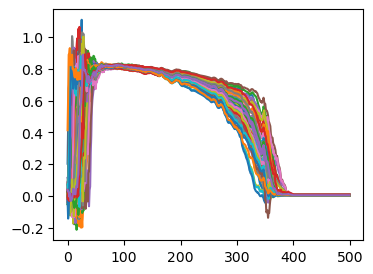

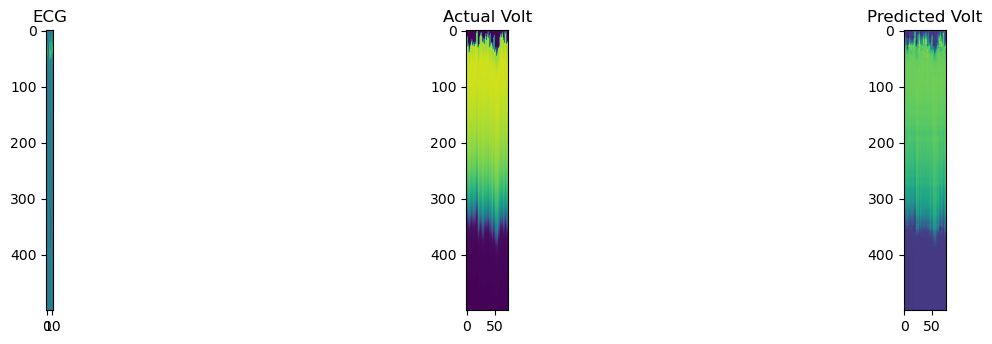

[[[-0.05082623 -0.00153633  0.02938429 ...  0.03000906  0.03831226
    0.03674231]
  [-0.04266506  0.01306573  0.04132918 ... -0.00622616 -0.02347241
    0.02824707]
  [-0.00528396 -0.00465034  0.03650776 ... -0.01255036 -0.02083237
    0.02731631]
  ...
  [ 0.00434777  0.00441245  0.00364574 ...  0.00479274  0.00844097
    0.00458916]
  [ 0.00434777  0.00441245  0.00364575 ...  0.00479276  0.00844098
    0.00458917]
  [ 0.00434777  0.00441244  0.00364575 ...  0.00479277  0.00844099
    0.00458919]]]


In [12]:


ecg2vm_mdl= keras.models.load_model('transVolt_v1_e768.h5')
ecg2vm_mdl.summary()

[X1, X2] = [ecgNorm_test, volt_test_T]
ix = np.random.randint(0, len(X1), 1)
src_ecg, tar_vm = X1[ix], X2[ix]

# generate image from source
gen_volt = ecg2vm_mdl.predict(src_ecg)
print(gen_volt.shape)

print(src_ecg.shape, tar_vm.shape, gen_volt.shape)

# plt.figure(figsize = (20//2, 10//2))
# plt.plot(range(500), src_ecg[0])
# plt.show()
# plt.figure(figsize = (20//2, 10//2))
# plt.plot(range(500), tar_vm[0])
# plt.show()
plt.figure(figsize = (4,3))
plt.plot(range(500), gen_volt[0])
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('ECG')
plt.imshow(src_ecg[0])

plt.subplot(232)
plt.title('Actual Volt')
plt.imshow(tar_vm[0])

plt.subplot(233)
plt.title('Predicted Volt')
plt.imshow(gen_volt[0])
plt.show()

print(gen_volt)

In [76]:
# print('input batch: ', ecg_trainBat32_T.shape)
# print(ecg_trainBat32_T[0, 0, 0,0:12], '\n')


print('ecg_norm_T: ', ecg_norm_T.shape)
print( ecg_norm_T[:, :, 2])

ecgTensor= np.load("ecgTensor.npy")
print(ecgTensor.shape)


ecg_norm_T:  (16117, 500, 12)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [98]:
print('vm_norm_T: ', vm_norm_T.shape)
print(vm_norm_T[0, 0, :])

vm_norm_T:  (16117, 500, 75)
[-0.00283363 -0.00307841  0.03913251 -0.00286193 -0.0030838   0.66750936
 -0.00285201 -0.00307829  0.03012389 -0.00273251 -0.00283587 -0.00307749
 -0.00307821  0.068473   -0.00307821 -0.00307821 -0.00550569 -0.00307881
 -0.002901   -0.00289026 -0.00307816 -0.0032477  -0.00276816 -0.00181996
  0.07610417 -0.00283153 -0.00182005  0.00728314 -0.00304997 -0.0018199
 -0.00294456 -0.00307753 -0.0018199  -0.00272946 -0.00281209 -0.00181992
 -0.00275588 -0.00275169 -0.00181998 -0.00283023 -0.00283378 -0.00181962
 -0.0029431  -0.0028127  -0.00182001 -0.00267319 -0.00181993 -0.00277165
 -0.00286199 -0.00276868 -0.0018199  -0.00298108 -0.0018164   0.07176278
 -0.00182033 -0.00270714  0.00083699 -0.00307821 -0.00307821 -0.00307821
 -0.00262309 -0.00089313 -0.00182081  0.00082975 -0.00182068 -0.00249596
 -0.00295852 -0.00181989 -0.00307973 -0.00288584 -0.00307819 -0.0030783
 -0.0028729  -0.00181991 -0.00278668]


In [ ]:
pECGData = vm_norm_T[0]

# Example of file pair
case = 213
# ECG plot
row = 3 
column = 25
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, pECGData))
# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
#bookmark

"""
#give me an example of the architecture that you mentioned ; use an autoencoder and a reconstruction loss to train the model to learn a compressed reprsentation of the input data
"""


# Define the input shape
input_shape = (28, 28, 1)

# Create a sequential model for the encoder
encoder = tf.keras.Sequential()

# Add a Conv2D layer to the encoder
encoder.add(tf.keras.layers.Conv2D(
    filters=16, # number of output filters
    kernel_size=3, # size of the convolution window
    strides=2, # stride of the convolution
    padding='same', # apply padding to the input
    activation='relu', # use ReLU activation function
    input_shape=input_shape # specify the input shape
))

# Add another Conv2D layer to the encoder
encoder.add(tf.keras.layers.Conv2D(
    filters=8, # number of output filters
    kernel_size=3, # size of the convolution window
    strides=2, # stride of the convolution
    padding='same', # apply padding to the input
    activation='relu' # use ReLU activation function
))

# Create a sequential model for the decoder
decoder = tf.keras.Sequential()

# Add a Conv2DTranspose layer to the decoder
decoder.add(tf.keras.layers.Conv2DTranspose(
    filters=8, # number of output filters
    kernel_size=3, # size of the convolution window
    strides=2, # stride of the transposed convolution
    padding='same', # apply padding to the input
    activation='relu', # use ReLU activation function
    input_shape=encoder.output_shape[1:] # specify the input shape as the output shape of the encoder
))

# Add another Conv2DTranspose layer to the decoder
decoder.add(tf.keras.layers.Conv2DTranspose(
    filters=16, # number of output filters
    kernel_size=3, # size of the convolution window
    strides=2, # stride of the transposed convolution
    padding='same', # apply padding to the input
    activation='relu' # use ReLU activation function
))

# Add a final Conv2D layer to the decoder to reconstruct the input image
decoder.add(tf.keras.layers.Conv2D(
    filters=1, # number of output filters (should be equal to the number of channels in the input image)
    kernel_size=3, # size of the convolution window
    padding='same', # apply padding to the input
    activation='sigmoid' # use sigmoid activation function to ensure pixel values are between 0 and 1
))

# Create an autoencoder model by chaining the encoder and decoder models together
autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile the autoencoder model with a binary cross-entropy loss function (since pixel values are between 0 and 1)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())

# Print a summary of the autoencoder model architecture
autoencoder.summary()

#In this example, we create an autoencoder model by chaining together an encoder and a decoder. The encoder consists of two Conv2D layers that downsample the input image and learn a compressed representation. The decoder consists of two Conv2DTranspose layers that upsample this compressed representation and reconstruct the original image.

'''
We compile the autoencoder model using a binary cross-entropy loss function since we assume that pixel values are between 0 and 1. This loss function measures how well the 
reconstructed image matches the original image.
To train this autoencoder model on some sample data, you can call its fit() method and pass in your training data as both x and y arguments. For example:

'''

# Define some sample training data (e.g., MNIST digits)
x_train = ...

# Train the autoencoder on this data for 10 epochs by trying to reconstruct it from its compressed representation.
history = autoencoder.fit(x_train, x_train, epochs=10)


In [13]:
#tmp-------------

# import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras, initializers
from keras import Model
from keras import layers
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

#------------------------------------------------------------------------Predict----------------------------------------------------------------|
vm_norm_T= np.load('vm_norm_T.npy')
print('vm_norm_T: ', vm_norm_T.shape)
print(vm_norm_T[0,0,:], '\n')


# ecgNorm= np.load('ecg_norm.npy')
ecgNorm= np.load('ecg_norm.npy')
print('ecgNorm: ', ecgNorm.shape)
print(ecgNorm[0,0,:])


ecgNorm_train, ecgNorm_test, volt_train_T, volt_test_T= train_test_split(ecgNorm, vm_norm_T, test_size= 0.05, random_state=42)
print('\necg_train, ecg_test, vm_train, vm_test: ', ecgNorm_train.shape, ecgNorm_test.shape, volt_train_T.shape, volt_test_T.shape)


print('\necgNorm_test: ', ecgNorm_test.shape)
print(ecgNorm_test[0,0,:])

print('\nvolt_test_T: ', volt_test_T.shape)
print(volt_test_T[0,0,:])



ecg2vm_mdl= keras.models.load_model('ecg2vm_mdl_e82.h5')
# ecg2vm_mdl.summary()

[X1, X2] = [ecgNorm_test, volt_test_T]
ix = np.random.randint(0, len(X1), 1)
src_ecg, tar_vm = X1[ix], X2[ix]
# generate image from source
# gen_volt = ecg2vm_mdl.predict(src_ecg)


print('results: ', gen_volt.shape)
print(gen_volt, '\n')

print(src_ecg.shape,'--->', tar_vm.shape,':==   ', gen_volt.shape)
#tmp-------------

# np.save('pred_base_e82.npy', gen_volt)
gen_volt= np.load('pred_base_e82.npy')
print('saved gen_volt: ', gen_volt.shape)



print(gen_volt.shape)
predAvg= np.mean(gen_volt, axis= 2)
print(predAvg.shape)
# plt.plot(predAvg[0])
vm_norm_T= np.load('vm_norm_T.npy')
vmAvg= np.mean(vm_norm_T, axis=2)
print(vmAvg.shape)
# plt.plot(vmAvg[0])
# np.save('vmTruth.npy', predAvg)
predAvg= np.load('vmTruth.npy')
print('vmTruth: ', predAvg.shape)



# print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = src_ecg

# print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = gen_volt

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time




vm_norm_T:  (16117, 500, 75)
[-0.00283363 -0.00307841  0.03913251 -0.00286193 -0.0030838   0.66750936
 -0.00285201 -0.00307829  0.03012389 -0.00273251 -0.00283587 -0.00307749
 -0.00307821  0.068473   -0.00307821 -0.00307821 -0.00550569 -0.00307881
 -0.002901   -0.00289026 -0.00307816 -0.0032477  -0.00276816 -0.00181996
  0.07610417 -0.00283153 -0.00182005  0.00728314 -0.00304997 -0.0018199
 -0.00294456 -0.00307753 -0.0018199  -0.00272946 -0.00281209 -0.00181992
 -0.00275588 -0.00275169 -0.00181998 -0.00283023 -0.00283378 -0.00181962
 -0.0029431  -0.0028127  -0.00182001 -0.00267319 -0.00181993 -0.00277165
 -0.00286199 -0.00276868 -0.0018199  -0.00298108 -0.0018164   0.07176278
 -0.00182033 -0.00270714  0.00083699 -0.00307821 -0.00307821 -0.00307821
 -0.00262309 -0.00089313 -0.00182081  0.00082975 -0.00182068 -0.00249596
 -0.00295852 -0.00181989 -0.00307973 -0.00288584 -0.00307819 -0.0030783
 -0.0028729  -0.00181991 -0.00278668] 

ecgNorm:  (16117, 500, 12)
[ 0.01639716  0.01695606  0.00

: 

: 

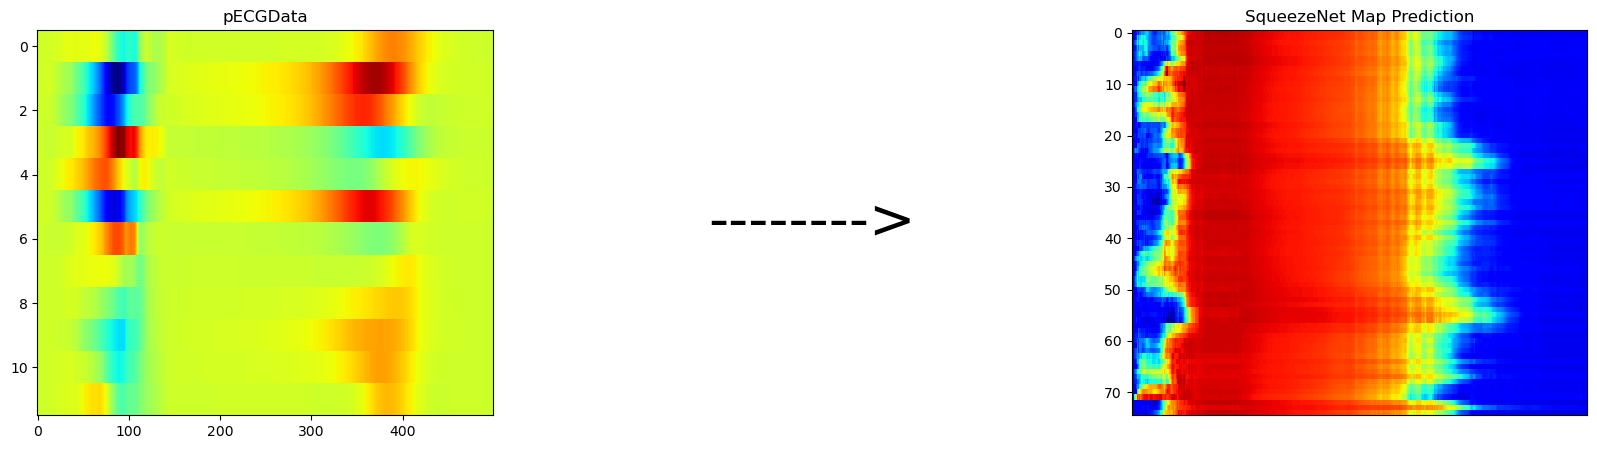

In [9]:
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('SqueezeNet Map Prediction')
plt.show()
plt.close()

In [1]:
def RSE(pred, true):
    return np.sqart(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))
def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0)
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean()
def Corr(pred, true):
    sig_p = np.std(pred, axis=0)
    sig_g = np.std(true, axis=0)
    m_p = pred.mean(0)
    m_g = true.mean(0)
    ind = (sig_g != 0)
    corr = ((pred - m_p) * (true - m_g)).mean(0) / (sig_p * sig_g)
    corr = (corr[ind]).mean()
    return corr
def MAE(pred, true):
    return np.mean(np.abs(pred-true))
def MSE(pred, true):
    return np.mean((pred-true)**2)
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))
def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    #corr1 = CORR(pred, true)
    corr = Corr(pred, true)
    return mae,mse,rmse,mape,mspe,corr

vm_norm_T= np.load('vm_norm_T.npy')
vmAvg= np.mean(vm_norm_T, axis=2)
print(vmAvg.shape)

NameError: name 'np' is not defined